In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import math
import scipy.stats as stats


In [274]:
#Data Preoprocessing
data = pd.read_csv('datasets/data.csv')
data = data.dropna()


In [275]:
data.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [276]:
data.describe()


,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
count,150149.000000,150149.000000,150149.000000,150149.000000,150149.000000,150149.000000,150149.000000,150149.000000
mean,106270.971795,9199.420935,254761.195226,206.626751,219.424262,0.095612,0.133201,51.674543
std,61385.825580,615.593192,85547.587866,103.308516,110.960204,0.294059,0.339793,60.207962
min,1.000000,8023.000000,216233.000000,41.325000,61.275000,0.000000,0.000000,1.000000
25%,53111.000000,8562.000000,217217.000000,130.387500,133.237500,0.000000,0.000000,20.000000
50%,106226.000000,9371.000000,222087.000000,198.075000,205.912500,0.000000,0.000000,35.000000
75%,159452.000000,9731.000000,245338.000000,233.700000,234.412500,0.000000,0.000000,62.000000
max,212644.000000,9984.000000,679023.000000,562.162500,562.162500,1.000000,1.000000,2876.000000


In [277]:
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
print(categorical_columns)

['week']



Create a new column 'key' for unique identification. This is done in order to handle the duplicate data in 'week' column.


In [278]:
# Removing columns that are not helpful for time series predictions.
data['key'] = data['week'].astype(str) + '_' + data['store_id'].astype(str)
data.drop(['week','record_ID', 'total_price','base_price','store_id','sku_id','is_featured_sku','is_display_sku'], axis=1, inplace=True)

data = data.groupby('key').agg({'units_sold':'sum'}).reset_index()



<Axes: xlabel='key'>

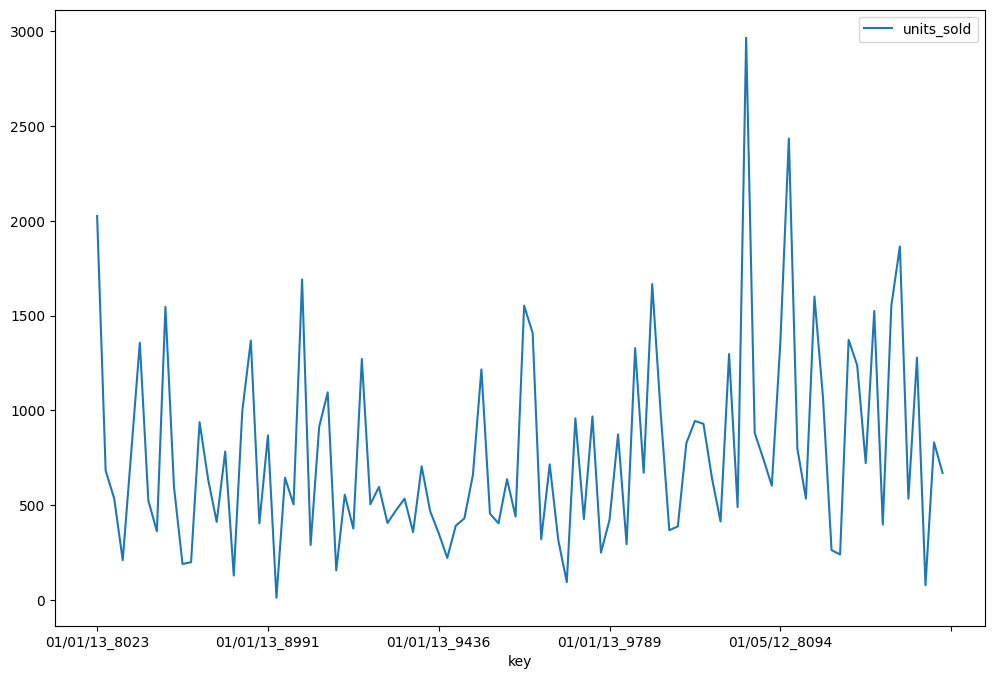

In [279]:
data[:100].plot(x='key', y='units_sold', kind='line',figsize=(12,8))

Since each store is open for 4 days in each week lets split the units_sold into 4 days , day1,day2,day3,and day4


In [280]:
data['day1'] = data['units_sold'].shift(-1)
data['day2'] = data['units_sold'].shift(-2)
data['day3'] = data['units_sold'].shift(-3)
data['day4'] = data['units_sold'].shift(-4)

In [281]:
data

,key,units_sold,day1,day2,day3,day4
0,01/01/13_8023,2025,682.0,535.0,210.0,782.0
1,01/01/13_8058,682,535.0,210.0,782.0,1357.0
2,01/01/13_8063,535,210.0,782.0,1357.0,524.0
3,01/01/13_8091,210,782.0,1357.0,524.0,362.0
4,01/01/13_8094,782,1357.0,524.0,362.0,1546.0
...,...,...,...,...,...,...
9875,31/10/11_9890,531,551.0,431.0,820.0,506.0
9876,31/10/11_9909,551,431.0,820.0,506.0,NaN
9877,31/10/11_9954,431,820.0,506.0,NaN,NaN
9878,31/10/11_9961,820,506.0,NaN,NaN,NaN


<Axes: xlabel='key'>

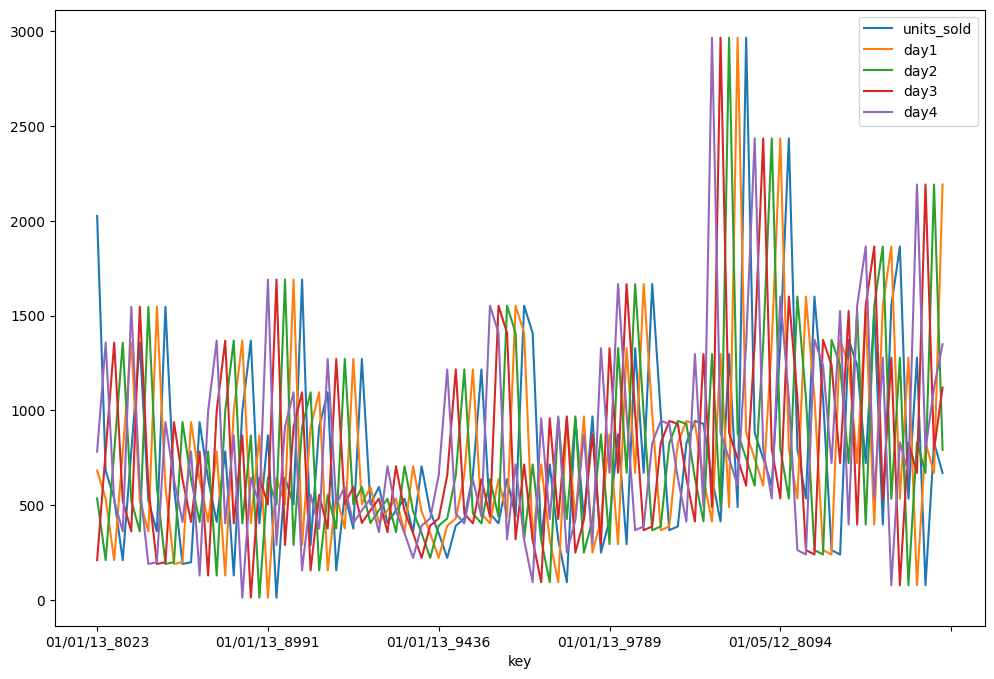

In [282]:
data[:100].plot(x = "key",figsize=(12,8))

**Train-Test Split**

In [283]:
df = train_data
x1, x2, x3, x4, y = df['day1'], df['day2'], df['day3'], df['day4'], df['units_sold']
x1, x2, x3, x4, y = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(y)
x1, x2, x3, x4, y = x1.reshape(-1,1), x2.reshape(-1,1), x3.reshape(-1,1), x4.reshape(-1,1), y.reshape(-1,1)

split_percentage = 15
test_split = int(len(df)*(split_percentage/100))
x = np.concatenate((x1, x2, x3, x4), axis=1)
X_train,X_test,y_train,y_test = x[:-test_split],x[-test_split:],y[:-test_split],y[-test_split:]



In [284]:
# train_data,test_data = train_test_split(data, test_size=0.15, shuffle=True)
# train_data = train_data.dropna()
# test_data = test_data.dropna()

# X_train = train_data.drop(['units_sold','key'], axis=1)
# y_train = train_data['units_sold']
# X_test = test_data.drop(['units_sold','key'], axis=1)
# y_test = test_data['units_sold']


# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

# Random Forest Regression


In [285]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)



/Library/Python/3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [290]:
print("R^2 Score for Random Forest Regression :", rf_model.score(X_test, y_test))



R^2 Score for Random Forest Regression : 0.5399278401285696


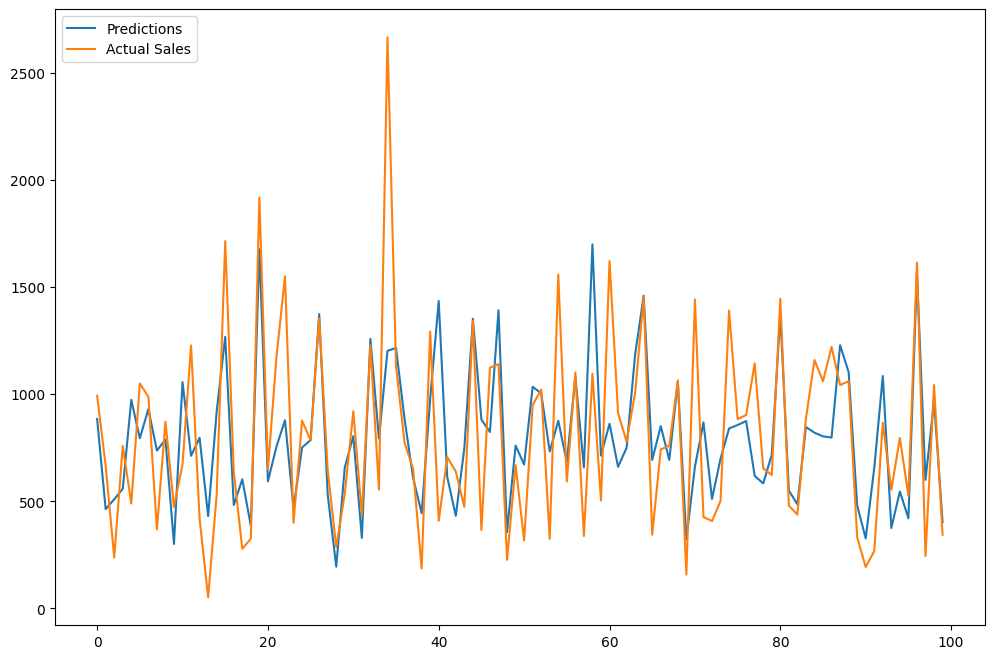

In [291]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(y_pred[-100:], label='Predictions')
plt.plot(y_test[-100:], label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

## XGBoost Regression

In [292]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print("R^2. Score for XGBoost Regression :", xgb_model.score(X_test, y_test))


R^2. Score for XGBoost Regression : 0.45884400606155396


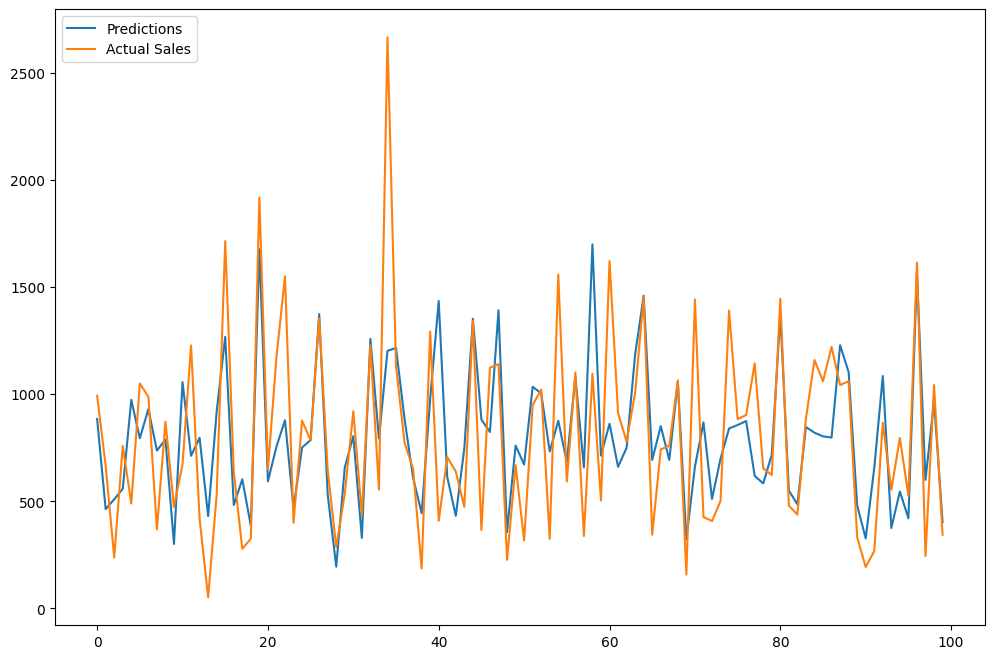

In [293]:
import matplotlib.pyplot as plt
plt.plot(y_pred[-100:], label='Predictions')
plt.plot(y_test[-100:], label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

Since efficiency of Random Forest Regression model is more than that of XGboost so will use Random Forest Regression for this dataset.


#### Hyperparameter Tuning for Random Forest

In [294]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 250, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(0, 120, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50, 72, 94, 116, 138, 161, 183, 205, 227, 250], 'max_features': ['auto', 'sqrt'], 'max_depth': [0, 6, 12, 18, 25, 31, 37, 44, 50, 56, 63, 69, 75, 82, 88, 94, 101, 107, 113, 120, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [295]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=0, n_jobs = -1)

In [296]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=94, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=94; total time=   0.0s
[CV] END bootstrap=True, max_depth=88, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=205; total time=   0.0s
[CV] END bootstrap=True, max_depth=56, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=116; total time=   0.0s
[CV] END bootstrap=True, max_depth=88, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=205; total time=   0.0s
[CV] END bootstrap=True, max_depth=56, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=116; total time=   0.0s
[CV] END bootstrap=True, max_depth=94, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=94; total time=   0.0s
[CV] END bootstrap=True, max_depth=88, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=205; total

/Library/Python/3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Python/3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Python/3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Library/Python/3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit

[CV] END bootstrap=True, max_depth=31, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=116; total time=   1.2s
[CV] END bootstrap=True, max_depth=31, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=116; total time=   1.4s
[CV] END bootstrap=False, max_depth=18, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=116; total time=   0.0s
[CV] END bootstrap=False, max_depth=18, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=116; total time=   0.0s
[CV] END bootstrap=False, max_depth=18, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=116; total time=   0.0s


/Library/Python/3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=31, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=116; total time=   1.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=205; total time=   3.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=205; total time=   3.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=205; total time=   3.0s
[CV] END bootstrap=False, max_depth=31, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time=   3.3s
[CV] END bootstrap=False, max_depth=31, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time=   3.4s
[CV] END bootstrap=False, max_depth=31, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=250; total time=   3.4s


/Library/Python/3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
21 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
17 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Python/3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Python/3.9/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Library/Python/3.9/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/Library/Python/3.9/site-packages/sklearn/utils/_param_validation.py", line 95,

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [0, 6, 12, 18, 25, 31, 37,
                                                      44, 50, 56, 63, 69, 75,
                                                      82, 88, 94, 101, 107, 113,
                                                      120, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 72, 94, 116, 138,
                                                         161, 183, 205, 227,
                                                         250]},
                   random_state=0, verbose=2)

In [298]:
rf_random.best_params_

{'n_estimators': 205,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [300]:
# Using the best parameters from the RandomizedSearchCV
best_rf_model = rf_random.best_estimator_
y_pred = best_rf_model.predict(X_test)
print("R^2 Score for Best Random Forest Regression :", best_rf_model.score(X_test, y_test))

R^2 Score for Best Random Forest Regression : 0.5380692002925385


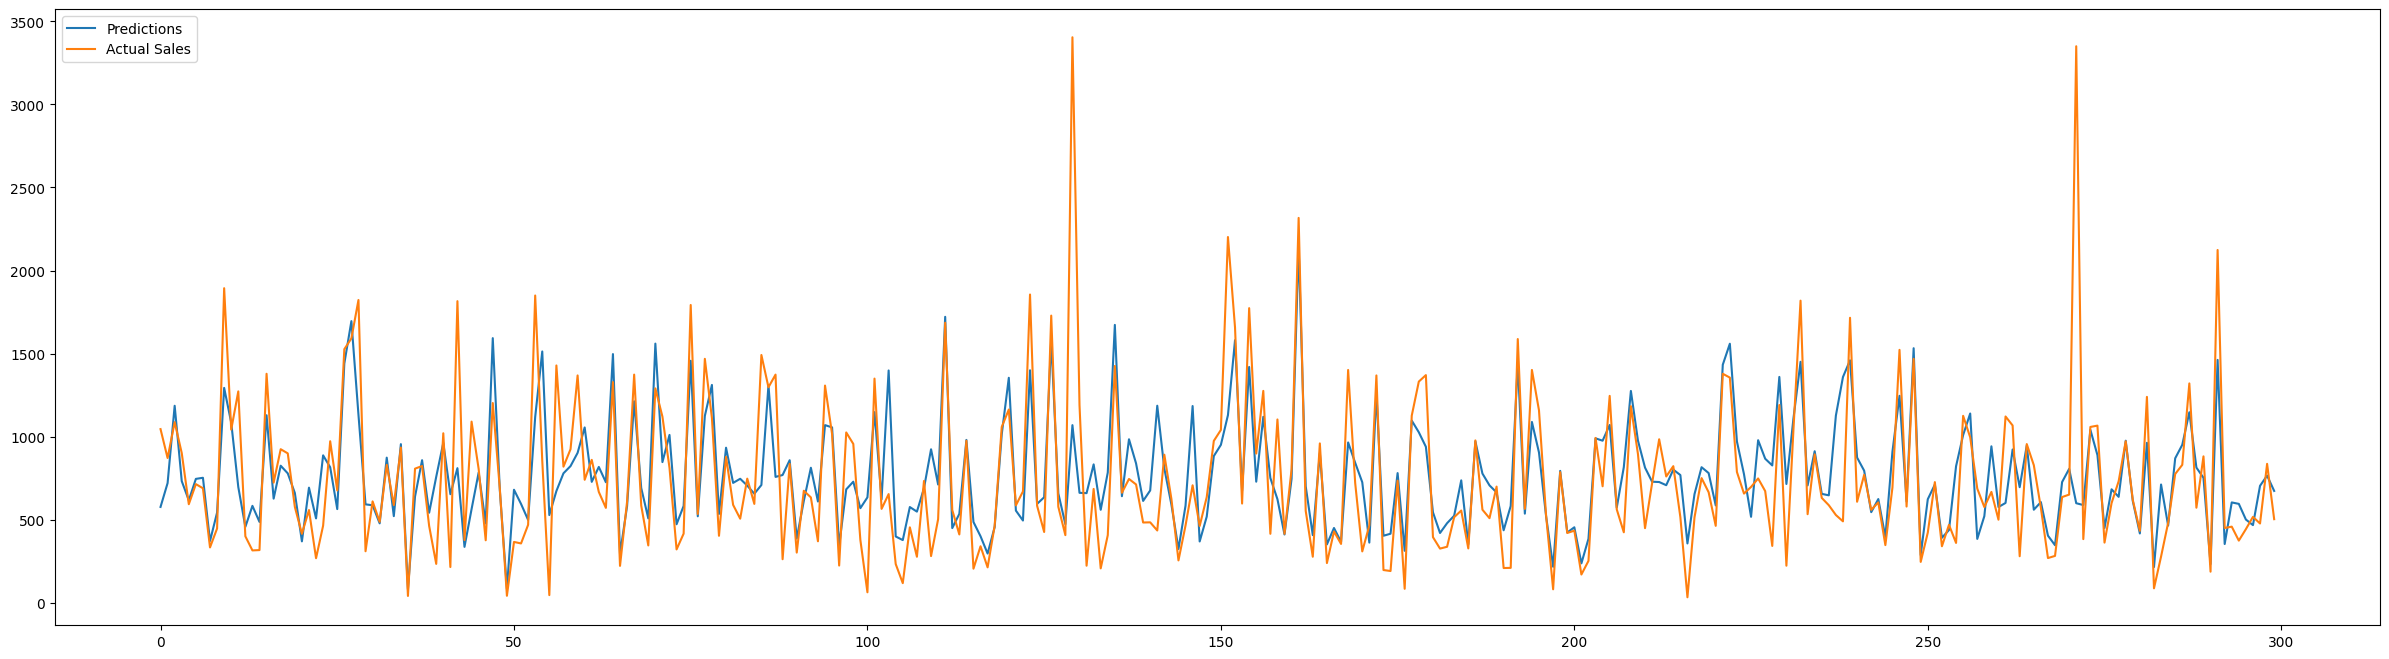

In [302]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,8)
plt.plot(y_pred[500:800], label='Predictions')
plt.plot(y_test[500:800], label='Actual Sales')
plt.legend(loc="upper left")
plt.savefig('final.png')
plt.show()